## Load the dataset

In [44]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


normalized_data = pd.read_csv('../Normalization/A1-turbine-normalized.csv')

X = normalized_data.iloc[:, :-1].values  # select all columns except the last as features
y = normalized_data.iloc[:, -1].values  # select the last column as the target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"X_train shape: {X_train.shape}")


X_train shape: (382, 4)


## Model definition

In [45]:
import numpy as np

class MyNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # initialize weights and biases with smaller initial values
        self.weights_input_to_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.bias_hidden = np.zeros(hidden_size)
        self.weights_hidden_to_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros(output_size)
        self.losses = []  # store training loss at each epoch

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0) * 1

    def forward_pass(self, x):
        # hidden layer
        hidden_layer_input = np.dot(x, self.weights_input_to_hidden) + self.bias_hidden
        hidden_layer_output = self.relu(hidden_layer_input)

        # output layer (Linear)
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
        output = output_layer_input
        return output, hidden_layer_output

    def backward_pass(self, x, y, output, hidden_output, learning_rate):
        # calculate error
        error = output - y

        # calculate gradients for output layer (linear)
        d_weights_hidden_to_output = np.dot(hidden_output.T, error)
        d_bias_output = np.sum(error, axis=0)

        # calculate gradients for hidden layer (ReLU)
        d_hidden_layer = np.dot(error, self.weights_hidden_to_output.T) * self.relu_derivative(hidden_output)
        d_weights_input_to_hidden = np.dot(x.T, d_hidden_layer)
        d_bias_hidden = np.sum(d_hidden_layer, axis=0)

        # update weights and biases
        self.weights_hidden_to_output -= learning_rate * d_weights_hidden_to_output
        self.bias_output -= learning_rate * d_bias_output
        self.weights_input_to_hidden -= learning_rate * d_weights_input_to_hidden
        self.bias_hidden -= learning_rate * d_bias_hidden

    def predict(self, x):
        output, _ = self.forward_pass(x)
        return output

    def train(self, x, y, learning_rate, epochs):
        for epoch in range(epochs):
            output, hidden_output = self.forward_pass(x)
            self.backward_pass(x, y, output, hidden_output, learning_rate)

            # calculate and store the loss
            loss = np.mean((output - y) ** 2)
            self.losses.append(loss)

            # printing the loss periodically
            if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}, Loss: {loss}")

    def loss_epochs(self):
        return np.array(self.losses)

    def mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## Model training

In [46]:
nn_turbine = MyNeuralNetwork(input_size=4, hidden_size=12, output_size=1)  
nn_turbine.train(X_train, y_train.reshape(-1, 1), learning_rate=0.001, epochs=500)

Epoch 0, Loss: 0.9738537516852431
Epoch 50, Loss: 0.015166758958712152
Epoch 100, Loss: 0.007262710705525112
Epoch 150, Loss: 0.004404752851075815
Epoch 200, Loss: 0.0031919723788933043
Epoch 250, Loss: 0.002671081072994128
Epoch 300, Loss: 0.002422041146282477
Epoch 350, Loss: 0.002254085249816672
Epoch 400, Loss: 0.0021488821922719162
Epoch 450, Loss: 0.0020947367678176036
Epoch 499, Loss: 0.002047209917338874


## Model Evaluation

In [47]:
predictions_train_turbine = nn_turbine.predict(X_train)  
train_mape_turbine = mean_absolute_percentage_error(y_train, predictions_train_turbine)
print(f"Turbine Data Training MAPE: {train_mape_turbine:.2f}%")

predictions_test_turbine = nn_turbine.predict(X_test)  
test_mape_turbine = mean_absolute_percentage_error(y_test, predictions_test_turbine)
print(f"Turbine Data Test MAPE: {test_mape_turbine:.2f}%")

Turbine Data Training MAPE: 0.13%
Turbine Data Test MAPE: 0.07%


## Predictions vs Actual Values Plot

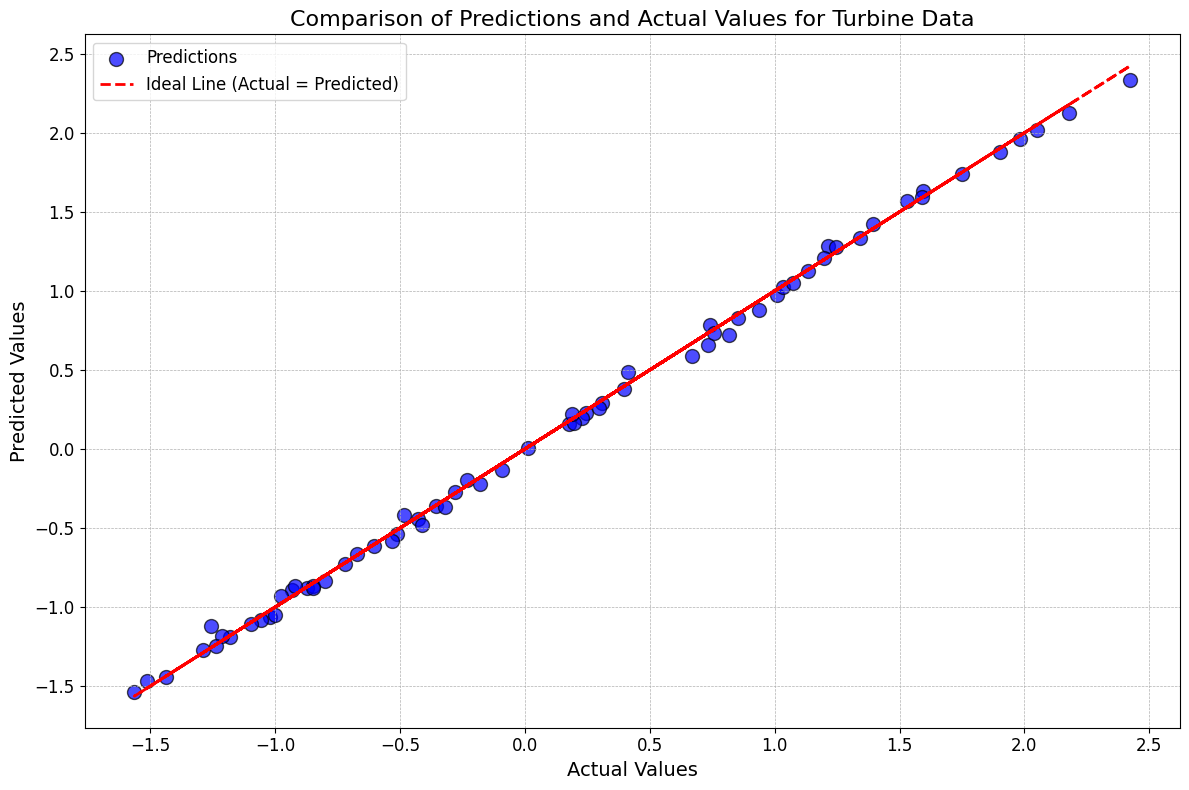

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.scatter(y_test, predictions_test_turbine, color='blue', edgecolor='k', label='Predictions', alpha=0.7, marker='o', s=100)
plt.plot(y_test, y_test, color='red', label='Ideal Line (Actual = Predicted)', linewidth=2, linestyle='--')
plt.title('Comparison of Predictions and Actual Values for Turbine Data', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
